In [4]:
from matplotlib import pyplot as plt
from collections import Counter, OrderedDict, defaultdict
import numpy as np
import pandas as pd
from utils import read_gbench, read_gset
from args import my_get_args
from simcim import SIMCIM
import itertools
import torch
import json
from scipy.signal import savgol_filter

BLS benchmarks for Gset

In [5]:
gbench = read_gbench('./data/gbench.txt')

# Performance

### Reinforcement learning (our approach)

In [6]:
ind = [0, 100, 200, 500]

agent_data = []

for g in range(1,11):
    for s in [1,2,3]:
        with open('checkpoints/ppo/ref-G{}-seed{}.res'.format(g, s)) as f:
            res = json.load(f)
        mx = np.array(res['train_max'])[ind].T/res['bls_bench']
        #mx = np.array([[np.max(np.array(res['train_max'])[:i+1,:]) for i in ind]]) / res['bls_bench']
        md = np.array(res['train_median'])[ind].T/res['bls_bench']
        solved = (mx >= 1).astype(float)
        agent_data.append(np.vstack([mx,md,solved]))

#agent_data = np.mean(agent_data, axis=0)
agent_data = np.array(agent_data).reshape(10,3,3,4) # graphs, seeds, statistics, checkpoints
agent_data = agent_data.mean(axis=0) # avg over graphs
agent_std = agent_data.std(axis=0) # std over seeds
agent_std[agent_std<1e-12] = 0 # remove numerical error 
agent_data = agent_data.mean(axis=0) # avg over seeds

In [7]:
print(agent_data)
print(agent_std)

[[0.99901538 0.99959747 0.99973805 0.99975526]
 [0.99008277 0.9900895  0.99252138 0.99788514]
 [0.13333333 0.6        0.73333333 0.8       ]]
[[1.56942243e-04 8.49911949e-05 1.21705126e-05 0.00000000e+00]
 [2.27353783e-03 1.30794004e-04 1.84749482e-03 4.14269059e-04]
 [4.71404521e-02 8.16496581e-02 4.71404521e-02 0.00000000e+00]]


### Heuristics (linear and manually tuned)

In [8]:
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    
def tanh_pump(O,S,D,Jmax,amin=0,amax=-1,N=1000):
    i = torch.arange(N,dtype=torch.float32)
    arg = torch.tensor(S,dtype = torch.float32)*(i/N-0.5)
    ret = (Jmax*O*(torch.tanh(arg).numpy() + D) + amin)/(amin-amax)
    return lambda i: float(ret[i])

In [ ]:
args = my_get_args('')

config = dict(
    sigma = args.sim_sigma,
    momentum = args.sim_momentum
)
config_tanh = dict(
    sigma = 0.3,
    momentum = 0.9
)
batch_size = 256

comp_data = []

topmax = []

for g in range(1,11):
    print(g)
    for seed in range(3):
        set_seed(seed)
        gr = read_gset('./data/G{}.txt'.format(g), negate=True)
        sim = SIMCIM(gr, device='cuda', batch_size=batch_size, **config)
        sim.runpump()
        mx = np.max(sim.lastcuts) / gbench[g]
        md = np.median(sim.lastcuts) / gbench[g]
        solved = float(mx >= 1)
        d1 = np.array([[mx,md,solved]]).T
        
        sim = SIMCIM(gr, device='cuda', batch_size=batch_size, **config_tanh)
        sim.lr = 0.3
        J = torch.max(torch.sum(torch.abs(torch.tensor(gr)),1)).item()
        tpump = tanh_pump(0.1, 2, -0.9, J, sim.mie, sim.me)
        sim.runpump(pumpfunc=tpump)
        mx = np.max(sim.lastcuts) / gbench[g]
        md = np.median(sim.lastcuts) / gbench[g]
        solved = float(mx >= 1)
        d2 = np.array([[mx,md,solved]]).T
        
        d = np.hstack([d1,d2])
        comp_data.append(d)
    
comp_data = np.array(comp_data).reshape(10,3,3,2) # graphs, seeds, statistics, checkpoints
comp_data = comp_data.mean(axis=0) # avg over graphs
comp_std = comp_data.std(axis=0) # std over seeds
comp_std[comp_std<1e-12] = 0 # remove numerical error 
comp_data = comp_data.mean(axis=0) # avg over seeds

In [77]:
print(comp_data)
print(comp_std)

[[0.99925806 0.99966039]
 [0.99422192 0.99462744]
 [0.2        0.66666667]]
[[1.84170468e-05 2.12398314e-05]
 [4.63447237e-05 2.80124629e-04]
 [0.00000000e+00 4.71404521e-02]]


### Black-box (CMA-ES)

In [10]:
from scipy.optimize import minimize
import cma

def make_sim_cost(g, config, batch_size, minb, maxb):
    gr = read_gset('./data/G{}.txt'.format(g), negate=True)
    sim = SIMCIM(gr, device='cuda', batch_size=batch_size, **config)
    J = torch.max(torch.sum(torch.abs(torch.tensor(gr)), 1)).item()
    
    def cost(x, raw=False):
        O, S, D = list(x*(maxb-minb) + minb)
        O = np.exp(O)
        S = np.exp(S)
        pump = tanh_pump(O, S, D, J, sim.mie, sim.me)
        sim.runpump(pumpfunc=pump)
        mx = np.max(sim.lastcuts)
        score = - (mx + np.mean(sim.lastcuts==mx))
        if raw:
            return sim.lastcuts, score
        else:
            return score
    return cost

In [ ]:
options = {
    'popsize': 10,
    'bounds': [np.array([0,0,0]), np.array([1,1,1])], 
    'maxfevals': 499,
    'maxiter': 100000
}

cma_data = []

for g in range(1,11):
    for seed in range(3):
        set_seed(seed)
        options['seed'] = seed+1
        sim_cost = make_sim_cost(g, config, batch_size, np.array([-2, -2, -3]), np.array([1,1,3]))

        es = cma.CMAEvolutionStrategy(3*[0.5], 0.5, options)
        while not es.stop():
            solutions = es.ask()
            es.tell(solutions, [sim_cost(x) for x in solutions])
            es.logger.add()
            #es.disp()
            
        cuts, score = sim_cost(es.best.x, raw=True)
        mx = np.max(cuts) / gbench[g]
        md = np.median(cuts) / gbench[g]
        solved = float(mx >= 1)
        d = np.array([[mx,md,solved]]).T
        cma_data.append(d)

        print("G{}, seed {} | best {}, reproduced {}".format(g, seed, -es.best.f, -score))
        
#cma_data = np.mean(cma_data, axis=0)

In [43]:
cma_data = np.array(cma_data).reshape(10,3,3,1) # graphs, seeds, statistics, checkpoints
cma_data = cma_data.mean(axis=0) # avg over graphs
cma_std = cma_data.std(axis=0) # std over seeds
cma_std[cma_std<1e-12] = 0 # remove numerical error 
cma_data = cma_data.mean(axis=0) # avg over seeds

In [44]:
print(cma_data)
print(cma_std)

[[0.99949732]
 [0.99331612]
 [0.6       ]]
[[8.31097558e-05]
 [3.94250958e-04]
 [0.00000000e+00]]


### Compile data in a table

In [89]:
data = pd.DataFrame(data=np.hstack([comp_data, cma_data, agent_data]), 
                    index = ['Maximum', 'Median', 'Solved'],
                    columns=['Linear', 'Manual', 'CMA-ES'] + ['Agent-{}'.format(i) for i in ind])
data_std = pd.DataFrame(data=np.hstack([comp_std, cma_std, agent_std]), 
                    index = ['Maximum', 'Median', 'Solved'],
                    columns=['Linear', 'Manual', 'CMA-ES'] + ['Agent-{}'.format(i) for i in ind])
data.loc['Maximum'] = ['{:.4f} ({:.0e})'.format(e,s) for e,s in 
                       zip(data.loc['Maximum'].values, data_std.loc['Maximum'].values)]
data.loc['Median']  = ['{:.4f} ({:.0e})'.format(e,s) for e,s in 
                       zip(data.loc['Median'].values, data_std.loc['Median'].values)]
data.loc['Solved']  = ['{:.4f} ({:.0e})'.format(e,s) for e,s in 
                       zip(data.loc['Solved'].values, data_std.loc['Solved'].values)]

data

,Linear,Manual,CMA-ES,Agent-0,Agent-100,Agent-200,Agent-500
Maximum,0.9993 (2e-05),0.9997 (2e-05),0.9995 (8e-05),0.9990 (2e-04),0.9996 (8e-05),0.9997 (1e-05),0.9998 (0e+00)
Median,0.9942 (5e-05),0.9946 (3e-04),0.9933 (4e-04),0.9901 (2e-03),0.9901 (1e-04),0.9925 (2e-03),0.9979 (4e-04)
Solved,0.2000 (0e+00),0.6667 (5e-02),0.6000 (0e+00),0.1333 (5e-02),0.6000 (8e-02),0.7333 (5e-02),0.8000 (0e+00)


In [90]:
print(data.to_latex())

\begin{tabular}{llllllll}
\toprule
{} &          Linear &          Manual &          CMA-ES &         Agent-0 &       Agent-100 &       Agent-200 &       Agent-500 \\
\midrule
Maximum &  0.9993 (2e-05) &  0.9997 (2e-05) &  0.9995 (8e-05) &  0.9990 (2e-04) &  0.9996 (8e-05) &  0.9997 (1e-05) &  0.9998 (0e+00) \\
Median  &  0.9942 (5e-05) &  0.9946 (3e-04) &  0.9933 (4e-04) &  0.9901 (2e-03) &  0.9901 (1e-04) &  0.9925 (2e-03) &  0.9979 (4e-04) \\
Solved  &  0.2000 (0e+00) &  0.6667 (5e-02) &  0.6000 (0e+00) &  0.1333 (5e-02) &  0.6000 (8e-02) &  0.7333 (5e-02) &  0.8000 (0e+00) \\
\bottomrule
\end{tabular}



# Ablation

### Ablation table

In [116]:
options = ['ref-G{}', 'nofilm-G{}', 'R2-G{}', 
           'scratch-G{}', 'nofilm-scratch-G{}', 'R2-scratch-G{}']
names = itertools.product(['Transfer', 'From scratch'], ['R3', 'R3, no FILM', 'R2'])

index = [100, 200, 500]

data = []

for g in range(1,11):
    for s in [1,2,3]:
        d = []
        for opt in options:
            fn = 'checkpoints/ppo/'+opt.format(g)+'-seed{}.res'.format(s)
            with open(fn) as f:
                res = json.load(f)
            mx = np.array(res['train_max'])[index] / res['bls_bench'][0]
            sl = (mx >= 1.).astype(float)
            d.append(sl)
        data.append(np.hstack(d))
        
data = np.array(data).reshape(10,3,3,6)
data = data.mean(axis=0)
data_std = data.std(axis=0)
data_std[data_std<1e-12] = 0
data = data.mean(axis=0)
data = [['{:.2f} ({:.0e})'.format(u,v) for u,v in zip(e,s)] for e,s in zip(data, data_std)]
data = pd.DataFrame(data=data, 
                    columns=pd.MultiIndex.from_tuples(names), 
                    index=['Solved ({} it.)'.format(i) for i in index])

In [117]:
data

Transfer                              From scratch  \
                            R3   R3, no FILM            R2            R3   
Solved (100 it.)  0.60 (8e-02)  0.63 (5e-02)  0.60 (8e-02)  0.40 (0e+00)   
Solved (200 it.)  0.73 (5e-02)  0.70 (0e+00)  0.67 (5e-02)  0.47 (5e-02)   
Solved (500 it.)  0.80 (0e+00)  0.77 (5e-02)  0.70 (0e+00)  0.73 (5e-02)   

                                              
                   R3, no FILM            R2  
Solved (100 it.)  0.37 (5e-02)  0.10 (8e-02)  
Solved (200 it.)  0.53 (9e-02)  0.33 (5e-02)  
Solved (500 it.)  0.73 (5e-02)  0.53 (5e-02)

In [118]:
print(data.to_latex(multicolumn=False))

\begin{tabular}{lllllll}
\toprule
{} &      Transfer &               &               &  From scratch &               &               \\
{} &            R3 &   R3, no FILM &            R2 &            R3 &   R3, no FILM &            R2 \\
\midrule
Solved (100 it.) &  0.60 (8e-02) &  0.63 (5e-02) &  0.60 (8e-02) &  0.40 (0e+00) &  0.37 (5e-02) &  0.10 (8e-02) \\
Solved (200 it.) &  0.73 (5e-02) &  0.70 (0e+00) &  0.67 (5e-02) &  0.47 (5e-02) &  0.53 (9e-02) &  0.33 (5e-02) \\
Solved (500 it.) &  0.80 (0e+00) &  0.77 (5e-02) &  0.70 (0e+00) &  0.73 (5e-02) &  0.73 (5e-02) &  0.53 (5e-02) \\
\bottomrule
\end{tabular}



### Ablation plot

In [134]:
options = ['ref-G{}', 'nofilm-G{}', 'R2-G{}', 
           'scratch-G{}', 'nofilm-scratch-G{}', 'R2-scratch-G{}']
names = list(itertools.product(['Transfer', 'From scratch'], ['R3', 'R3, no FILM', 'R2']))

colors = ['g', 'y', 'r', 'b--', 'c--', 'm--']

data = []

for g in range(1,11):
    for s in [1,2,3]:
        d = []
        for opt in options:
            fn = 'checkpoints/ppo/'+opt.format(g)+'-seed{}.res'.format(s)
            with open(fn) as f:
                res = json.load(f)
            mx = np.array(res['train_max']) / res['bls_bench'][0]
            sl = (mx >= 1.).astype(float)
            d.append(sl)
            #d.append(mx)
        data.append(np.hstack(d))

data = np.array(data).reshape(10,3,-1,6)
data = np.mean(data, axis=0)
mean = np.mean(data, axis=0)
std =  np.std(data, axis=0)

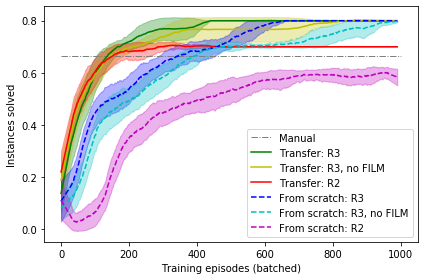

In [143]:
plt.plot([0,1000], [0.666, 0.666], 'gray', label='Manual', ls='-.', lw=1)
for m,s,l,c in zip(mean.T, std.T, names, colors):
    m = savgol_filter(m, 51, 1)
    s = savgol_filter(s, 51, 1)
    plt.plot(m, c, label=': '.join(l))
    plt.fill_between(np.arange(m.size), m - s, m + s, color=c.strip('-'), alpha=0.3)
plt.legend()
#plt.ylim(0.999)
#plt.title('Ablation study: fraction of solved instances')
plt.ylabel('Instances solved')
plt.xlabel('Training episodes (batched)')
plt.tight_layout()
#plt.savefig('plots_paper/ablation_std.pdf')
plt.show()

# Analysis

### G2: percentiles

In [57]:
data = []

options = ['ref-G{}-seed{}.res', 'R2-G{}-seed{}.res', 'scratch-G{}-seed{}.res', 'R2-scratch-G{}-seed{}.res']
names = list(itertools.product(['Transfer', 'From scratch'], ['R3', 'R2']))
colors = ['g', 'r', 'b--', 'm--']
graph = 2

data = []
for s in [1,2,3]:
    d = []
    for opt in options:
        with open('checkpoints/ppo/'+opt.format(graph, s)) as f:
            res = json.load(f)
        baseline = res['bls_bench'][0]
        perc = np.array(res['train_percentiles']) + baseline
        #perc = np.array(res['train_max'])
        d.append(perc)
    data.append(np.hstack(d))
data = np.mean(data, axis=0)

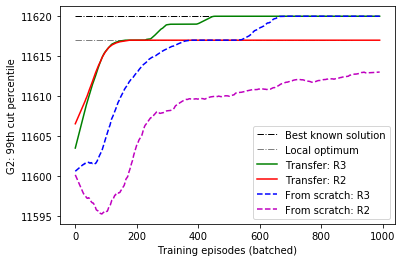

In [58]:
plt.plot([0,900],[baseline,baseline], 'black', ls='-.', lw=1, label='Best known solution')
plt.plot([0,900],[baseline-3,baseline-3], 'gray', ls='-.', lw=1,  label='Local optimum')
for d,l,c in zip(data.T, names, colors):
    d = savgol_filter(d, 51, 1)
    plt.plot(d, c, label=': '.join(l))
plt.ylabel('G2: 99th cut percentile')
plt.xlabel('Training episodes (batched)')
plt.legend()
plt.savefig('plots_paper/g2.pdf')
plt.show()

### G2: median

In [144]:
args = my_get_args('')
config = dict(
    sigma = args.sim_sigma,
    momentum = args.sim_momentum
)
batch_size = 256

data = []
g = 2

for seed in range(3):
    set_seed(seed)
    gr = read_gset('./data/G{}.txt'.format(g), negate=True)
    sim = SIMCIM(gr, device='cuda', batch_size=batch_size, **config)

    J = torch.max(torch.sum(torch.abs(torch.tensor(gr)),1)).item()
    tpump = tanh_pump(0.1, 2, -0.9, J, sim.mie, sim.me)
    sim.runpump(pumpfunc=tpump)
    md = np.median(sim.lastcuts)

    data.append(md)
    
median = np.mean(data)
median

/home/dmitrii/anaconda3/envs/sim/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


11593.667

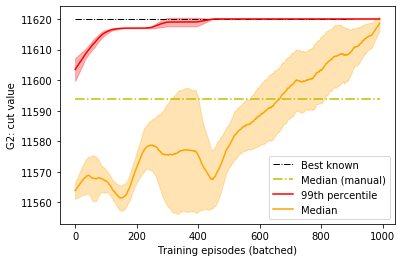

In [159]:
perc = []
med = []
graph = 2

for s in [1,2,3]:
    with open('checkpoints/ppo/ref-G{}-seed{}.res'.format(graph, s)) as f:
        res = json.load(f)
    perc.append(res['train_percentiles'])
    med.append(res['train_median'])
perc_std = np.std(perc, axis=0)
perc = np.mean(perc, axis=0)
med_std = np.std(med, axis=0)
med = np.mean(med, axis=0)
baseline = res['bls_bench'][0]

plt.plot([0,900],[baseline,baseline], 'black', ls='-.', lw=1, label='Best known')
plt.plot([0,990],[median,median], 'y', ls='-.', label='Median (manual)')
mx = perc.ravel() + baseline
mx_std = perc_std.ravel()
md = med.ravel()
md_std = med_std.ravel()
mx = savgol_filter(mx, 51, 1)
md = savgol_filter(md, 51, 1)
mx_std = savgol_filter(mx_std, 51, 1)
md_std = savgol_filter(md_std, 51, 1)
plt.plot(mx, 'r', label='99th percentile', alpha=1.0)
plt.fill_between(np.arange(mx.size), mx - mx_std, mx + mx_std, color='r', alpha=0.3)
plt.plot(md, 'orange', label='Median')
plt.fill_between(np.arange(md.size), md - md_std, md + md_std, color='orange', alpha=0.3)
plt.ylabel('G2: cut value')
plt.xlabel('Training episodes (batched)')
plt.legend()

#plt.savefig('plots_paper/median_std.pdf')

### G2: regularization functions

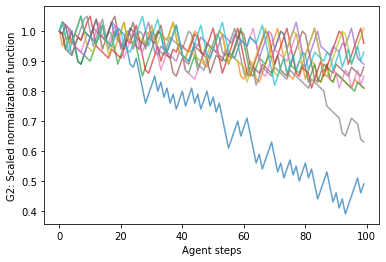

In [10]:
plt.plot(res['spumps'], alpha=0.7)
plt.ylabel('G2: Scaled normalization function')
plt.xlabel('Agent steps')
#plt.tight_layout()
plt.savefig('plots_paper/pumps.pdf')
plt.show()

### G2: losses

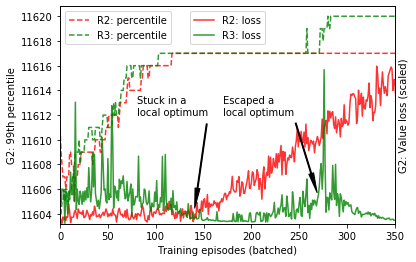

In [90]:
with open('checkpoints/ppo/ref-G2-seed3.res') as f:
    res = json.load(f)
with open('checkpoints/ppo/R2-G2-seed3.res') as f:
    res1 = json.load(f)
baseline = res['bls_bench'][0]

fig, ax1 = plt.subplots()

ax = ax1.twinx()
#ax1.plot([0,900],[baseline,baseline], 'black', ls='-.', lw=1, label='Best known')
ax1.plot(np.array(res1['train_percentiles']) + baseline, 'r--', label='R2: percentile', alpha=0.8)
ax1.plot(np.array(res['train_percentiles']) + baseline, 'g--', label='R3: percentile', alpha=0.8)
ax1.set_ylabel('G2: 99th percentile')

loss1 = np.array(res1['vlosses'])/12
loss = np.array(res['vlosses'])
# loss1 = savgol_filter(loss1, 3, 1)
# loss  = savgol_filter(loss,  3, 1)
ax.plot(loss1, 'r', label='R2: loss', alpha=0.8)
ax.plot(loss, 'g', label='R3: loss', alpha=0.8)
ax.set_xlim(0,350)
ax.set_yticks([],[])
ax.set_ylabel('G2: Value loss (scaled)')
ax.set_ylim(0, 0.004) #0.003
ax.annotate('Stuck in a\nlocal optimum', xy=(140,0.0002), xytext=(80, 0.002),
            arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=5, headlength=20))
ax.annotate('Escaped a\nlocal optimum', xy=(270,0.0005), xytext=(170, 0.002),
            arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=5, headlength=20))

ax1.set_xlabel('Training episodes (batched)')

ax1.legend(loc=2)
ax.legend(loc=9)
plt.savefig('plots_paper/loss.pdf')
plt.show()

# Exact cut values

In [49]:
agent = []
bls = []
prob = []

for g in range(1,11):
    with open('checkpoints/ppo/ref-G{}-seed3.res'.format(g)) as f:
        res = json.load(f)
    agent.append(res['train_max'][-1][0])
    bls.append(res['bls_bench'][0])
    prob.append(np.mean(res['stoch_cuts']==np.max(res['stoch_cuts'])).round(2))
    
agent = np.array(agent)
bls = np.array(bls)
data = np.vstack([bls, agent, agent-bls]).astype(int)
data = pd.DataFrame(data, columns=['G'+str(g) for g in range(1,11)], index=['BLS *', 'Agent', 'Difference'])

In [50]:
print(data.to_latex().replace('*','\\cite{bls}'))

\begin{tabular}{lrrrrrrrrrr}
\toprule
{} &     G1 &     G2 &     G3 &     G4 &     G5 &    G6 &    G7 &    G8 &    G9 &   G10 \\
\midrule
BLS \cite{bls}      &  11624 &  11620 &  11622 &  11646 &  11631 &  2178 &  2006 &  2005 &  2054 &  2000 \\
Agent      &  11624 &  11620 &  11622 &  11646 &  11631 &  2178 &  2006 &  2005 &  2050 &  1999 \\
Difference &      0 &      0 &      0 &      0 &      0 &     0 &     0 &     0 &    -4 &    -1 \\
\bottomrule
\end{tabular}



In [51]:
print('Frequency & ' + ' & '.join(map(str, prob)) + ' \\\\')

Frequency & 0.87 & 0.49 & 0.81 & 0.93 & 0.34 & 0.53 & 0.82 & 0.92 & 0.61 & 0.46 \\
